# Sequence alginment training data generation V1
This notebook file consists of the required functions and processes required to generate model training data from a genomic sequence string index file. Its assumed that the suffix array, BWT and occurance array are already computed. Note the only column required for training data generation is the suffix array and orgignal reference location (org_location).

## Contents:
* [Importing indexed sequence string data](#first-bullet)
* [Adding string variation](#second-bullet)
* [Reverse complement of sequence strings](#third-bullet)
* [Runlength encoding](#forth-bullet)
* [Binary encoding](#fith-bullet)
* [Feature analysis](#sixth-bullet)


## Importing indexed sequence string <a class="anchor" id="first-bullet"></a>

In [1]:
import pandas as pd

sequence = pd.read_csv('P1_dataset/indexed_reference.csv')
seed_set = pd.DataFrame({'org_location':sequence['org_location'],
                            'seed':sequence['seed'],})

seed_set.head(3)

,org_location,seed
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGG
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCT
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTA


In [2]:
#import vaex
#v_sequence = vaex.from_csv('P1_dataset/indexed_reference.csv', convert = True, copy_index= False) # attempt with vaex for larger d processing

## Adding sequence variation to tolerate 1 mismatch <a class="anchor" id="second-bullet"></a>

In [3]:
# %%time
# 
# ''' Data cleaning - removing special characters '''
# 
# # def spec_char_removal(sequence_data_set):
# #     """ vaex implamentation of this preprocessing"""
# #     sequences = sequence_data_set.seed.values
# #     s_strings = vaex.from_arrays(text=sequences) 
# #     s_strings.text.str.title().str.replace('$', '')
# #     s_strings.text.str.upper()
# #     sequence_data_set.seed = s_strings
# #     return sequence_data_set
# 
# 
# def spec_char_removal(sequence_data_set):
#     """ Pandas implamentation of this preprocessing"""
#     sequences = sequence_data_set['seed']
#     sequence_string = []
# 
#     for s_string in sequences:
#         clean_sequence = s_string.replace('$', '')
#         sequence_string.append(clean_sequence)
#     
#     sequence_data_set['seed'] = sequence_string
#     return sequence_data_set
# 
# new_seq = spec_char_removal(sequence) # pandas imp
# # new_seq = spec_char_removal(v_sequence) # vaex imp
#     

In [4]:
# ''' Adding Sequence variaiton '''
# 
# def sequence_variation(sequence):
#     """ add single character variation into the sequence string """
#     sequence_variants = []
#     options = ["A", "T", "C", "G"]
#     for count, char in enumerate(sequence):
#         temp_list = list(sequence.strip())
#         for j in range(len(options)):
#             character = options[j]
#             temp_list[count] = character
#             new_string = "".join(temp_list)
#             sequence_variants.append(new_string)
#     return sequence_variants
# 
# def variation_check(data_set):
#     """ Varaition check to ensure max number of string variation within training = 1 """    
#     variation_scores = []
#     for count in range(len(data_set)):
#         string1 = data_set['seeds'].iloc[count]
#         string2 = data_set['org_sequence'].iloc[count]
# 
#         current_score = 0
# 
#         for count, char in enumerate(string1):
#             max_score = len(string1) 
#             if char == string2[count]:
#                 current_score += 1
#                 
#         variation_score = max_score - current_score
#         variation_scores.append(variation_score)
#         
#     data_set['total_variation'] = variation_scores
#     
#     print("mean variation: ", round(data_set['total_variation'].mean(),2))
#     print("max variation: ", data_set['total_variation'].max())
#     print("min variation: ", data_set['total_variation'].min())
#     print("Total number of variants checked ", len(data_set))
#     return data_set
# 
# 
# 
# print("Total seed lenght: ", len(sequence['seed'][0]))
# print("Total variants per seed: ", len(sequence_variation(sequence['seed'][0])))
# 
# seeds = []
# 
# # iterate through seeds and process sequence variation
# for count, seed in enumerate(sequence['seed']):
#     _alignment_location = sequence['org_location'][count]
#     _seeds = sequence_variation(seed)
#     seed_var = pd.DataFrame({'org_location':_alignment_location,
#                             'org_sequence':seed,
#                             'seeds':_seeds})
#     seeds.append(seed_var)
#     
# df_var = pd.concat(seeds)
# 
# print("Total number of sequence strings processed: ", len(seeds))
# 
# variation_check(df_var)

## Reverse complament <a class="anchor" id="third-bullet"></a>
The reverse complement of a DNA sequence is formed by reversing the letters, interchanging A and T and interchanging C and G. Thus the reverse complement of ACCTGAG is CTCAGGT. The complement is the Watson-Crick counterpart of the DNA string -> This counterpart is called its complementary nucleotide. This gets into double stranded analysis which is prob not a road we want to go down. However 

- Original sequence: ACGTATAGGCTGACACGTAGAGATGGATGACCATAG
- Reverse sequence: GATACCAGTAGGTAGAGATGCACAGTCGGATATGCA
- Complement sequence: TGCATATCCGACTGTGCATCTCTACCTACTGGTATC
- Reverse complement: CTATGGTCATCCATCTCTACGTGTCAGCCTATACGT -> results in a representation of its partner strand

http://genewarrior.com/docs/exp_revcomp.jsp#:~:text=The%20complementary%20sequence%20is%20thus,to%20its%205%E2%80%B2%2Dend.

This should prob be before runlength encoding


In [10]:
""" Reverse complament using biopython """

from Bio.Seq import Seq

def reverse_complement(sequence_set):
    sequence_strings = sequence_set['seed']
    
    rc_strings = []
    clean_rc_strings = []
    for string in sequence_strings:
        s_seq = Seq(string)
        rc_string = s_seq.reverse_complement()
        rc_strings.append(rc_string)
        
    for row in rc_strings:
        new_string = ''.join(row)
        clean_rc_strings.append(new_string)
    
    sequence_set['rc_seeds'] = clean_rc_strings
    return sequence_set

df_var_complete = reverse_complement(seed_set)

In [11]:
df_var_complete

,org_location,seed,rc_seeds
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGG,CCATACTAGTTAGAGAACCTCCGAAAA$
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCT,AGGAGGAGAGTTCCTGATATCTTTTTTT
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTA,TACGGCTTGCGTCCAGCCAGAGTTTTTT
3,8072,AAAAAAGATATCAGGAACTCTCCTCCTC,GAGGAGGAGAGTTCCTGATATCTTTTTT
4,565,AAAAAAGCACGTGGTGGCGCCCACCGAC,GTCGGTGGGCGCCACCACGTGCTTTTTT
...,...,...,...
9996,9042,TTTTTTATCTAAAGACGATGAGAGGAGT,ACTCCTCTCATCGTCTTTAGATAAAAAA
9997,7100,TTTTTTCCTTGGTCCTCGAGAAGAGGAG,CTCCTCTTCTCGAGGACCAAGGAAAAAA
9998,7471,TTTTTTGTCCTTTTATCCGCTCACTTAG,CTAAGTGAGCGGATAAAAGGACAAAAAA
9999,7099,TTTTTTTCCTTGGTCCTCGAGAAGAGGA,TCCTCTTCTCGAGGACCAAGGAAAAAAA


## Run length encoding of sequence string varients <a class="anchor" id="forth-bullet"></a>

In [12]:
""" Run length encoding """
from collections import OrderedDict

def runLengthEncoding(input):
    dict = OrderedDict.fromkeys(input, 0)

    for ch in input:
        dict[ch] += 1
    output = ''
    characters = ''
    values = ''
    for key, value in dict.items():
        output = output + key + str(value)
        characters = characters + key
        values = values + str(value)
    # print(characters)
    # print(values)
    return output, characters, values

output = []
character = []
value = []

for seed_string in df_var_complete['seed']:
    out, char, val = runLengthEncoding(seed_string)
    output.append(out)
    character.append(char)
    value.append(val)
    
df_var_complete['runlength_output'] = output
df_var_complete['runlength_character'] = character
df_var_complete['runlength_value'] = value

del output
del character
del value

rc_output = []
rc_character = []
rc_value = []

for rc_seed_string in df_var_complete['rc_seeds']:
    rc_out, rc_char, rc_val = runLengthEncoding(rc_seed_string)
    rc_output.append(rc_out)
    rc_character.append(rc_char)
    rc_value.append(rc_val)
    
df_var_complete['runlength_rc_output'] = rc_output
df_var_complete['runlength_rc_character'] = rc_character
df_var_complete['runlength_rc_value'] = rc_value

del rc_output
del rc_character
del rc_value
    

In [13]:
#df_var = df_var.drop('total_variation', axis=1)
df_var_complete

,org_location,seed,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
0,0,$TTTTCGGAGGTTCTCTAACTAGTATGG,CCATACTAGTTAGAGAACCTCCGAAAA$,$1T11C4G7A5,$TCGA,111475,C7A11T5G4$1,CATG$,711541
1,8071,AAAAAAAGATATCAGGAACTCTCCTCCT,AGGAGGAGAGTTCCTGATATCTTTTTTT,A12G3T6C7,AGTC,12367,A6G7T12C3,AGTC,67123
2,8754,AAAAAACTCTGGCTGGACGCAAGCCGTA,TACGGCTTGCGTCCAGCCAGAGTTTTTT,A10C7T4G7,ACTG,10747,T10A4C7G7,TACG,10477
3,8072,AAAAAAGATATCAGGAACTCTCCTCCTC,GAGGAGGAGAGTTCCTGATATCTTTTTT,A11G3T6C8,AGTC,11368,G8A6T11C3,GATC,86113
4,565,AAAAAAGCACGTGGTGGCGCCCACCGAC,GTCGGTGGGCGCCACCACGTGCTTTTTT,A9G8C9T2,AGCT,9892,G9T9C8A2,GTCA,9982
...,...,...,...,...,...,...,...,...,...
9996,9042,TTTTTTATCTAAAGACGATGAGAGGAGT,ACTCCTCTCATCGTCTTTAGATAAAAAA,T10A9C2G7,TACG,10927,A10C7T9G2,ACTG,10792
9997,7100,TTTTTTCCTTGGTCCTCGAGAAGAGGAG,CTCCTCTTCTCGAGGACCAAGGAAAAAA,T10C5G8A5,TCGA,10585,C8T5G5A10,CTGA,85510
9998,7471,TTTTTTGTCCTTTTATCCGCTCACTTAG,CTAAGTGAGCGGATAAAAGGACAAAAAA,T15G3C7A3,TGCA,15373,C3T3A15G7,CTAG,33157
9999,7099,TTTTTTTCCTTGGTCCTCGAGAAGAGGA,TCCTCTTCTCGAGGACCAAGGAAAAAAA,T11C5G7A5,TCGA,11575,T5C7G5A11,TCGA,57511


## Binarny encoding of char values 

In [15]:
## utf-8 string encoding

def encode(index):
        '''encode the data set using 2bit encoding'''
        encoded =[]
        dictionary = {'$': '', ',':'', 'A': '00', 'C': '01', 'G': '10', 'T': '11'}

        if isinstance(index, list):
            # encode list of strings
            for i in range(len(index)):
                substring = index[i]
                transTable = substring.maketrans(dictionary)
                txt = substring.translate(transTable)
                encoded.append(txt)
        else:
            # encode single string
            transTable = index.maketrans(dictionary)
            txt = index.translate(transTable)
            encoded = txt
        return encoded

In [20]:
df_var_complete.dtypes
df_var_complete.to_csv('data_set.csv', index = False)

In [17]:
#org_sequence_encoded = encode(df_var_compleate['org_sequence'].tolist())
seeds_encoded = encode(df_var_complete['seed'].tolist())
rc_seeds_encoded = encode(df_var_complete['rc_seeds'].tolist())
runlength_output_encoded = encode(df_var_complete['runlength_output'].tolist())
runlength_character_encoded = encode(df_var_complete['runlength_character'].tolist())
runlength_rc_output_encoded = encode(df_var_complete['runlength_rc_output'].tolist())
runlength_rc_character_encoded = encode(df_var_complete['runlength_rc_character'].tolist())

In [18]:
df_var_encoded = pd.DataFrame({
    "org_location":df_var_complete['org_location'],
    #"org_sequence":org_sequence_encoded,
    "seeds":seeds_encoded,
    "rc_seeds":rc_seeds_encoded,
    "runlength_output":runlength_output_encoded,
    "runlength_character":runlength_character_encoded,
    "runlength_value":df_var_complete['runlength_value'],
    "runlength_rc_output":runlength_rc_output_encoded,
    "runlength_rc_character":runlength_rc_character_encoded,
    "runlength_rc_value":df_var_complete['runlength_rc_value']
})

In [19]:
df_var_encoded

,org_location,seeds,rc_seeds,runlength_output,runlength_character,runlength_value,runlength_rc_output,runlength_rc_character,runlength_rc_value
0,0,1111111101101000101011110111011100000111001011...,0101001100011100101111001000100000010111010110...,11111014107005,11011000,111475,01700111151041,01001110,711541
1,8071,0000000000000010001100110100101000000111011101...,0010100010100010001011110101111000110011011111...,0012103116017,00101101,12367,0061071112013,00101101,67123
2,8754,0000000000000111011110100111101000011001000010...,1100011010011111100110110101001001010010001011...,0010017114107,00011110,10747,1110004017107,11000110,10477
3,8072,0000000000001000110011010010100000011101110101...,1000101000101000100010111101011110001100110111...,0011103116018,00101101,11368,1080061111013,10001101,86113
4,565,0000000000001001000110111010111010011001010100...,1011011010111010100110010100010100011011100111...,009108019112,00100111,9892,109119018002,10110100,9982
...,...,...,...,...,...,...,...,...,...
9996,9042,1111111111110011011100000010000110001110001000...,0001110101110111010011011011011111110010001100...,1110009012107,11000110,10927,0010017119102,00011110,10792
9997,7100,1111111111110101111110101101011101100010000010...,0111010111011111011101100010100001010000101000...,1110015108005,11011000,10585,0181151050010,01111000,85510
9998,7471,1111111111111011010111111111001101011001110100...,0111000010111000100110100011000000001010000100...,1115103017003,11100100,15373,0131130015107,01110010,33157
9999,7099,1111111111111101011111101011010111011000100000...,1101011101111101110110001010000101000010100000...,1111015107005,11011000,11575,1150171050011,11011000,57511


In [94]:
df_var_encoded = df_var_encoded.astype('float64')
#df_var_encoded = df_var_encoded.astype('int64')

In [95]:
df_var_encoded.dtypes

org_location              float64
seeds                     float64
rc_seeds                  float64
runlength_output          float64
runlength_character       float64
runlength_value           float64
runlength_rc_output       float64
runlength_rc_character    float64
runlength_rc_value        float64
dtype: object

In [109]:
training_data_varient_1 = df_var_encoded.drop(['seeds', 'rc_seeds'], axis=1)

In [110]:
#df_var_encoded.to_csv("training_data.csv", index = False)
training_data_varient_1.to_csv("training_data.csv", index = False)

## Feature analysis <a class="anchor" id="fith-bullet"></a>

In [ ]:
https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
https://medium.com/@hongwy1128/intro-guide-to-factor-analysis-python-84dd0b0fd729

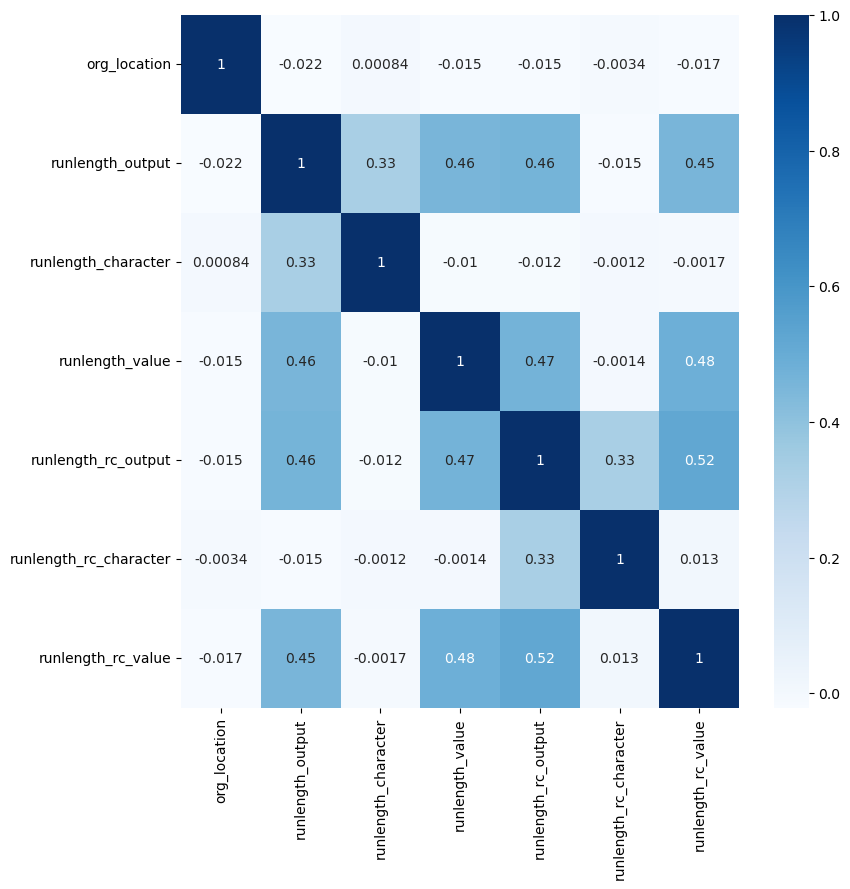

In [111]:
## Correlation matrix 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = training_data_varient_1

X = data.iloc[1:]  #independent columns
y = data.iloc[0]    #target column i.e price range

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(9,9))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="Blues")

## univariate selection (ANOVA - analysis of variance)

In [98]:
#factor analysis

!pip install factor-analyzer
#Instantiate factor analysis object
from factor_analyzer.factor_analyzer import FactorAnalyzer 


### Adequacy Test

In [113]:
# Bartlett’s Test

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(training_data_varient_1)
chi_square_value, p_value

# p-value = 0, test is statisitcally significant and correlations exsist (not identiy matrix) - we can proceed

(1584452.241417992, 0.0)

Bartlett's Test of Sphericity

- https://www.datacamp.com/tutorial/introduction-factor-analysis
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
- https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html#factor_analyzer.factor_analyzer.FactorAnalyzer.corr_

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

It tests whether the correlation coefficients are all 0. The test computes the probability that the correlation matrix has significant correlations among at least some of the variables in a dataset, a prerequisite for factor analysis to work.

This code imports the calculate_bartlett_sphericity function from the factor_analyzer module and uses it to calculate the Bartlett's test of sphericity for a given dataset df.
- The Bartlett's test of sphericity is a statistical test that checks whether the observed variables in a dataset are uncorrelated or not.
- The calculate_bartlett_sphericity function returns two values: the chi-square value and the p-value.
- These values are then printed to the console using the print function.
- The chi-square value is a measure of the difference between the observed correlation matrix and the identity matrix, while the p-value is the probability of obtaining a chi-square value as extreme as the one observed, assuming that the null hypothesis (i.e., the variables are uncorrelated) is true.

In [114]:
# Kaiser-Meyer-Olkin Test

from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(training_data_varient_1)

kmo_model

0.662003956080479

The Kaiser-Meyer-Olkin (KMO) Test is a measure of how suited your data is for Factor Analysis. The test measures sampling adequacy for each variable in the model and for the complete model. The statistic is a measure of the proportion of variance among variables that might be common variance. The lower the proportion, the more suited your data is to Factor Analysis.

KMO returns values between 0 and 1. A rule of thumb for interpreting the statistic:

- KMO values between 0.8 and 1 indicate the sampling is adequate.
- KMO values less than 0.6 indicate the sampling is not adequate and that remedial action should be taken. Some authors put this value at 0.5, so use your own judgment for values between 0.5 and 0.6.
- KMO Values close to zero means that there are large partial correlations compared to the sum of correlations. In other words, there are widespread correlations which are a large problem for factor analysis.

For reference, Kaiser put the following values on the results:

- 0.00 to 0.49 unacceptable.
- 0.50 to 0.59 miserable.
- 0.60 to 0.69 mediocre.
- 0.70 to 0.79 middling.
- 0.80 to 0.89 meritorious.
- 0.90 to 1.00 marvelous.

<b>Remove factors with low loading to improve KMO</b>

In [115]:
fa = FactorAnalyzer(rotation='varimax')
fa.fit(training_data_varient_1)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([2.45707666, 1.18144011, 1.05603009, 0.99914636, 0.52120663,
       0.4359047 , 0.34919543])

In [119]:
sorted(ev)

[0.34919543246314233,
 0.43590470466685033,
 0.5212066339031479,
 0.999146360932889,
 1.056030094268223,
 1.181440114358164,
 2.457076659407586]

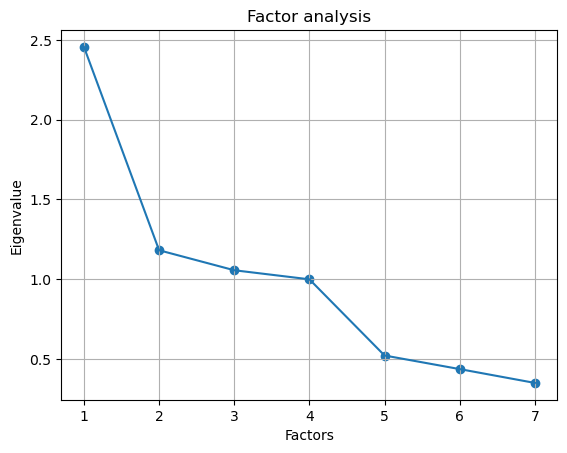

In [121]:
plt.scatter(range(1, training_data_varient_1.shape[1]+1), ev)
plt.plot(range(1, training_data_varient_1.shape[1] + 1), ev)
plt.title('Factor analysis')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()     

In [122]:
# Factor loadings
factor_loadings = pd.DataFrame(fa.loadings_, columns=['Factor1', 'Factor2', 'Factor3'], index=[df_var_encoded.columns])
factor_loadings

ValueError: Shape of passed values is (7, 3), indices imply (9, 3)

Text(0.5, 1.0, 'Factor Coverage')

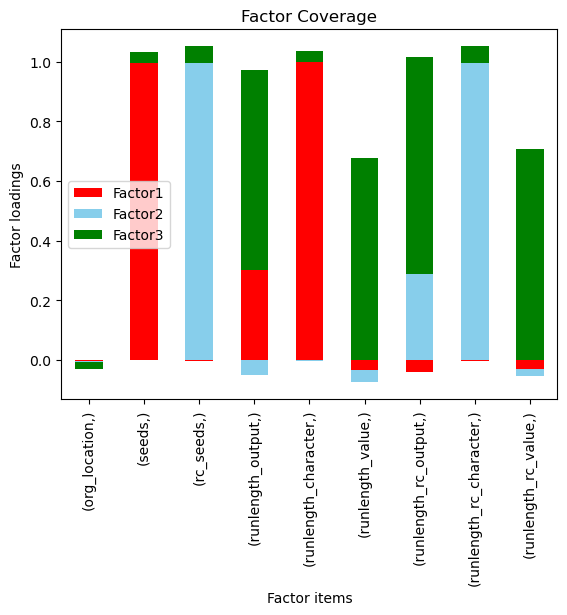

In [105]:
# create stacked bar chart for monthly temperatures
factor_loadings.plot(kind='bar', stacked=True, color=['red', 'skyblue', 'green'])
 
# labels for x & y axis
plt.xlabel('Factor items')
plt.ylabel('Factor loadings')
 
# title of plot
plt.title('Factor Coverage')

In [106]:
# variance coverage
# Get variance of each factors
variance = fa.get_factor_variance()
factor_variance = pd.DataFrame(variance, columns=['Factor1', 'Factor2', 'Factor3'], index = ['Sum of squared loadings (variance)', 'Proportional variance', 'Cumulative variance'] )

In [107]:
factor_variance

,Factor1,Factor2,Factor3
Sum of squared loadings (variance),2.080005,2.073174,1.945287
Proportional variance,0.231112,0.230353,0.216143
Cumulative variance,0.231112,0.461464,0.677607


A total of 76% of variance is explained by the above 3 factors. Each factor encomposes the following items from the dataset:
    
- Factor 1: Seeds, runlength characters 
- Factor 2: rc_seeds, rc_renlength characters 
- Factor 3: runlength_output, runlength_rc_output, runlenght_value, runlength_rc_value 

Text(0.5, 1.0, 'Factor Coverage')

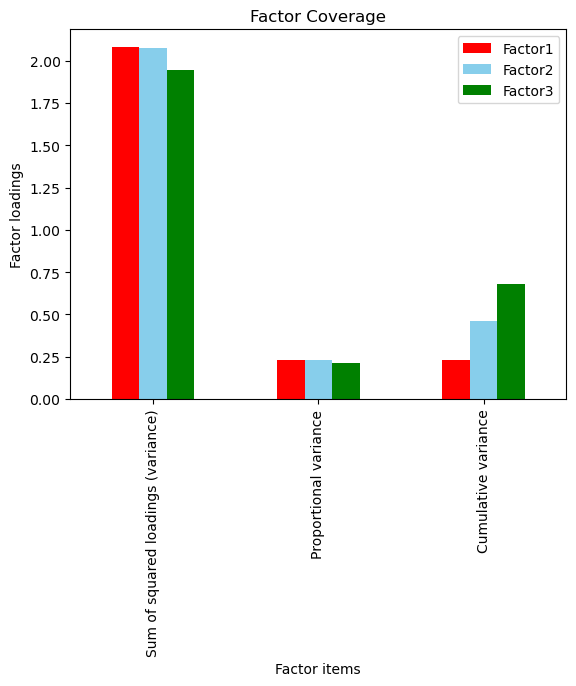

In [108]:
# create stacked bar chart for monthly temperatures
factor_variance.plot(kind='bar', stacked=False, color=['red', 'skyblue', 'green'])
 
# labels for x & y axis
plt.xlabel('Factor items')
plt.ylabel('Factor loadings')
 
# title of plot
plt.title('Factor Coverage')

In [ ]:
test models with each factor set: 
    F1
    F1, F2,
    F1, F3,
    F1, F2, F3

### runlength encoding test

In [49]:
out, char, val = runLengthEncoding('ATTTCGGAGGTTCTCTAACTAGTATGG')

In [50]:
print("output: ", out)
print("char: ", char)
print("val: ", val)

output:  A6T10C4G7
char:  ATCG
val:  61047
